## Fruit trait prediction from image inputs

Input is an image and output is a multi scalar regression vector for the predicted fruit traits
these traits are measurements of the fruit.

The data is standardized

In [1]:
from fastai.vision.all import *

from fastcore.basics import Int
from fastcore.transform import DisplayedTransform
from fastcore.xtras import Path

from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fine_tune

from fastai.data.block import DataBlock, RegressionBlock
from fastai.data.transforms import RandomSplitter, get_image_files, ColReader

from fastai.losses import MSELossFlat

from fastai.torch_core import ShowTitle, show_title, TitledFloat

from fastai.vision.augment import Resize, aug_transforms, Flip, Rotate, Zoom, Warp
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet50

from datetime import datetime, timedelta


import pandas as pd
from scipy.io import loadmat
import numpy as np

from scipy.io import loadmat
from datetime import datetime, timedelta

from fastai.metrics import mae, rmse, R2Score
from sklearn.model_selection import train_test_split

In [2]:
n_out_val      = 12
img_resize_val = 512

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = '/content/drive/MyDrive/School/ITS 530/Colab Notebooks/Mini Project 2 - Watermelonanalyzer/PhenotypeDataUGA.csv'

In [5]:
AllData = pd.read_csv(PATH)

In [6]:
AllData

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,147,6742,84.32,16.80,31.41,87.67,17.61,32.41,101.6,112.0,90.94,0.19,1.09,0.2
1,132,6744,75.96,18.63,25.27,82.09,19.57,26.66,118.3,122.7,73.39,0.18,0.93,0.2
2,20,6745,69.47,18.00,23.02,73.99,18.98,24.28,124.0,136.9,65.64,0.18,0.92,0.2
3,83,6746,74.58,14.73,27.44,80.63,15.52,28.92,108.6,101.7,63.50,0.18,0.81,0.2
4,119,6748,79.19,15.29,30.22,84.72,16.08,31.85,100.5,88.6,73.25,0.18,0.90,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,453,7714,79.37,16.03,22.55,85.12,16.89,31.21,96.8,105.8,76.44,0.18,0.93,0.2
291,677,7722,54.35,15.63,16.64,58.76,16.44,17.33,144.5,139.6,48.75,0.21,0.87,0.2
292,1410,7723,49.77,14.02,15.43,57.10,14.79,16.22,138.5,143.7,37.69,0.20,0.69,0.2
293,1434,7727,67.71,18.25,22.06,73.26,19.23,23.25,145.2,126.5,69.12,0.20,0.98,0.2


## Standardize the traits in the pandas dataframe ( [2:14] )

In [7]:

## df.iloc[:, 0:3]   ## example


y_means      = AllData.iloc[:, 2:14].mean()
y_deviations = AllData.iloc[:, 2:14].std()




In [8]:
y_means

perimeter1_cm                 75.753559
width1_cm                     18.553390
heigth1_cm                    25.259797
perimeter2_cm                 79.709186
width2_cm                     19.539322
heigth2_cm                    26.717593
prox_angl_macr               124.682373
distal_angl_macr             123.686102
tomat_pericap_area            79.054915
tomat_pericap_area_ratio       0.185288
tomat_pericap_thick            1.020000
tomat_pericap_thick_ratio      0.200102
dtype: float64

In [9]:
y_deviations

perimeter1_cm                10.012201
width1_cm                     2.579065
heigth1_cm                    4.272636
perimeter2_cm                 9.814579
width2_cm                     2.687700
heigth2_cm                    4.339802
prox_angl_macr               14.715583
distal_angl_macr             18.939076
tomat_pericap_area           23.384338
tomat_pericap_area_ratio      0.025724
tomat_pericap_thick           0.219342
tomat_pericap_thick_ratio     0.001300
dtype: float64

In [10]:

## normalized_df=(df-df.min())/(df.max()-df.min())


In [11]:
AllData.iloc[:, 2:14] = ( AllData.iloc[:, 2:14] - y_means ) / y_deviations

In [12]:
AllData

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,147,6742,0.855600,-0.679855,1.439440,0.811121,-0.717834,1.311674,-1.568567,-0.617037,0.508250,0.183168,0.319136,-0.07822
1,132,6744,0.020619,0.029705,0.002388,0.242579,0.011414,-0.013271,-0.433715,-0.052067,-0.242253,-0.205570,-0.410318,-0.07822
2,20,6745,-0.627590,-0.214570,-0.524219,-0.582724,-0.208104,-0.561683,-0.046371,0.697706,-0.573671,-0.205570,-0.455909,-0.07822
3,83,6746,-0.117213,-1.482471,0.510271,0.093821,-1.495450,0.507490,-1.092880,-1.160886,-0.665185,-0.205570,-0.957409,-0.07822
4,119,6748,0.343225,-1.265338,1.160923,0.510548,-1.287094,1.182636,-1.643317,-1.852577,-0.248239,-0.205570,-0.547091,-0.07822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,453,7714,0.361203,-0.978413,-0.634221,0.551304,-0.985721,1.035164,-1.894751,-0.944402,-0.111823,-0.205570,-0.410318,-0.07822
291,677,7722,-2.137748,-1.133508,-2.017442,-2.134497,-1.153150,-2.163139,1.346710,0.840268,-1.295949,0.960645,-0.683864,-0.07822
292,1410,7723,-2.595190,-1.757765,-2.300640,-2.303633,-1.767058,-2.418911,0.938979,1.056752,-1.768915,0.571907,-1.504500,-0.07822
293,1434,7727,-0.803376,-0.117636,-0.748904,-0.657103,-0.115088,-0.799021,1.394279,0.148576,-0.424853,0.571907,-0.182364,-0.07822



## Create DataLoader

We need to create a tuple of (x,y) for our model to train on. So we'll create it like this

(image_id, [column names])

Let's create a new column combined which is a list of the dependent variables.

In [13]:
headers_list = AllData.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))

['line', 'photo_id', 'perimeter1_cm', 'width1_cm', 'heigth1_cm', 'perimeter2_cm', 'width2_cm', 'heigth2_cm', 'prox_angl_macr', 'distal_angl_macr', 'tomat_pericap_area', 'tomat_pericap_area_ratio', 'tomat_pericap_thick', 'tomat_pericap_thick_ratio']
14
(0, 'line')
(1, 'photo_id')
(2, 'perimeter1_cm')
(3, 'width1_cm')
(4, 'heigth1_cm')
(5, 'perimeter2_cm')
(6, 'width2_cm')
(7, 'heigth2_cm')
(8, 'prox_angl_macr')
(9, 'distal_angl_macr')
(10, 'tomat_pericap_area')
(11, 'tomat_pericap_area_ratio')
(12, 'tomat_pericap_thick')
(13, 'tomat_pericap_thick_ratio')


In [14]:
list_of_traits = [ 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
                  'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
                  'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio' ]

AllData['combined'] = AllData[ list_of_traits ].values.tolist()

In [15]:
AllData

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
0,147,6742,0.855600,-0.679855,1.439440,0.811121,-0.717834,1.311674,-1.568567,-0.617037,0.508250,0.183168,0.319136,-0.07822,"[0.8556001570706825, -0.6798548454527973, 1.4394399212641362, 0.8111212774804382, -0.7178337696244309, 1.31167441807962, -1.5685666144189667, -0.6170365140707609, 0.5082497928177809, 0.18316827877113348, 0.31913642081116506, -0.07821984063462172]"
1,132,6744,0.020619,0.029705,0.002388,0.242579,0.011414,-0.013271,-0.433715,-0.052067,-0.242253,-0.205570,-0.410318,-0.07822,"[0.02061891083281533, 0.029704629303495104, 0.0023880782021850613, 0.24257929435097725, 0.011414206474745139, -0.013270933841795108, -0.4337152455653336, -0.0520670423922915, -0.2422525430727678, -0.20557015459206263, -0.4103182553286403, -0.07821984063462172]"
2,20,6745,-0.627590,-0.214570,-0.524219,-0.582724,-0.208104,-0.561683,-0.046371,0.697706,-0.573671,-0.205570,-0.455909,-0.07822,"[-0.6275902145360548, -0.21456994397326115, -0.5242188675452725, -0.5827235843853381, -0.20810431694286383, -0.5616830968979636, -0.04637076637577007, 0.6977055274987612, -0.5736709535087652, -0.20557015459206263, -0.4559091725873782, -0.07821984063462172]"
3,83,6746,-0.117213,-1.482471,0.510271,0.093821,-1.495450,0.507490,-1.092880,-1.160886,-0.665185,-0.205570,-0.957409,-0.07822,"[-0.1172129216801336, -1.4824713005049979, 0.5102712214341779, 0.09382099768986295, -1.4954502339342661, 0.5074901957829705, -1.0928804119054678, -1.1608856316677918, -0.6651851984549632, -0.20557015459206263, -0.9574092624334942, -0.07821984063462172]"
4,119,6748,0.343225,-1.265338,1.160923,0.510548,-1.287094,1.182636,-1.643317,-1.852577,-0.248239,-0.205570,-0.547091,-0.07822,"[0.34322530142471896, -1.2653383464812147, 1.1609233588465915, 0.5105480068295579, -1.287093669334502, 1.182636262066405, -1.6433173033853732, -1.85257722783489, -0.24823945629354716, -0.20557015459206263, -0.5470910071048539, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,453,7714,0.361203,-0.978413,-0.634221,0.551304,-0.985721,1.035164,-1.894751,-0.944402,-0.111823,-0.205570,-0.410318,-0.07822,"[0.3612033665351044, -0.9784126572354997, -0.6342212073236301, 0.551303704544932, -0.9857207812526991, 1.0351640837655864, -1.8947514389996514, -0.9444020023330515, -0.11182336219150445, -0.20557015459206263, -0.4103182553286403, -0.07821984063462172]"
291,677,7722,-2.137748,-1.133508,-2.017442,-2.134497,-1.153150,-2.163139,1.346710,0.840268,-1.295949,0.960645,-0.683864,-0.07822,"[-2.1377476838083695, -1.1335076243953452, -2.017442118153619, -2.134496774898186, -1.1531501635203667, -2.163138783133415, 1.3467102552709052, 0.8402679175484679, -1.295949269929926, 0.9606451454975246, -0.6838637588810675, -0.07821984063462172]"
292,1410,7723,-2.595190,-1.757765,-2.300640,-2.303633,-1.767058,-2.418911,0.938979,1.056752,-1.768915,0.571907,-1.504500,-0.07822,"[-2.595189562728158, -1.7577648672137238, -2.3006396312000295, -2.303632920416986, -1.7670578985018164, -2.4189108423738968, 0.9389792245450489, 1.056751546883208, -1.7689154143714914, 0.5719067121343295, -1.5045002695383485, -0.07821984063462172]"
293,1434,7727,-0.803376,-0.117636,-0.748904,-0.657103,-0.115088,-0.799021,1.394279,0.148576,-0.424853,0.571907,-0.182364,-0.07822,"[-0.8033757400598168, -0.11763558949835771, -0.7489044977308547, -0.6571027327158938, -0.1150879934608261, -0.7990211338508436, 1.3942788755222542, 0.1485763213813703, -0.4248533963065365, 0.5719067121343295, -0.18236366903495146, -0.07821984063462172]"


## Split data train and test

In [16]:

train, test = train_test_split(AllData, test_size=0.3)


In [17]:
print(  len(test)  )

print(  len(train) )

89
206


In [18]:
train

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
253,1115,7407,0.725759,-0.966781,1.345821,0.803989,-1.078737,1.362368,-2.513144,-2.216903,-0.515085,-0.983047,-1.048591,-0.07822,"[0.7257585757179044, -0.9667805346985122, 1.3458209086868107, 0.803989030380247, -1.0787371047347367, 1.362367979370528, -2.5131435022671993, -2.216903335739697, -0.5150847312768532, -0.9830470213184537, -1.04859109695097, -0.07821984063462172]"
10,459,6761,-0.342938,0.293366,-0.517197,-0.340227,0.290463,-0.593943,0.476884,0.940590,-0.351300,-0.205570,-0.227955,-0.07822,"[-0.34293751695496427, 0.2933660734752323, -0.5171974416019728, -0.3402271829788645, 0.29046317692085827, -0.5939426359012678, 0.4768840563890779, 0.9405895994352991, -0.3512998910226765, -0.20557015459206263, -0.22795458629368934, -0.07821984063462172]"
106,391,6928,-0.274022,0.684981,-0.692733,-0.372832,0.673690,-0.817455,1.326324,1.236275,0.264069,0.960645,0.729455,-0.07822,"[-0.27402160069848835, 0.6849808655538427, -0.6927330901844587, -0.37283174115116413, 0.6736904296668541, -0.8174551561384455, 1.3263237037346114, 1.2362745565754323, 0.2640692607417109, 0.9606451454975246, 0.7294546761398049, -0.07821984063462172]"
21,478,6777,0.814650,-0.710874,1.598592,0.817235,-0.736437,1.620444,-1.602544,-2.839954,-0.631402,-1.760524,-1.185364,-0.07822,"[0.8146501198748066, -0.7108738388847672, 1.5985922426455907, 0.8172346321377445, -0.7364370343208387, 1.6204442913969597, -1.602544200312788, -2.8399537811421207, -0.6314019024234225, -1.7605238880448448, -1.1853638487271836, -0.07821984063462172]"
286,849,7456,1.502811,1.832684,0.947940,1.615027,1.827093,0.956819,0.986548,0.724106,1.318194,-0.205570,0.820637,-0.07822,"[1.5028105010445323, 1.8326836225366996, 0.9479401052331754, 1.6150274149161816, 1.827092840844121, 0.9568194890432766, 0.986547844796398, 0.7241059701005589, 1.3181936242574956, -0.20557015459206263, 0.8206365106572806, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,484,6995,0.798670,0.180922,0.725595,0.840669,0.175123,0.712569,-0.025984,0.275298,1.559381,1.738122,1.686864,-0.07822,"[0.798669617554465, 0.18092222228434468, 0.7255949503620268, 0.8406691583240832, 0.17512293580313198, 0.7125686937325455, -0.02598421483947746, 0.2752984458699992, 1.5593806997231765, 1.7381220122239167, 1.686863938573299, -0.07821984063462172]"
162,1635,7198,0.790679,0.704368,0.706871,0.785649,0.714618,0.719481,0.259428,-0.184069,0.953847,0.183168,0.866227,-0.07822,"[0.7906793663942941, 0.7043677364488238, 0.706871147846562, 0.7856489664083297, 0.7146176119989505, 0.7194814520903967, 0.259427506668622, -0.18406925540127964, 0.9538471911072124, 0.18316827877113348, 0.8662274279160185, -0.07821984063462172]"
51,255,6828,0.109510,-0.187428,0.070262,-0.151732,-0.208104,-0.008662,-0.250236,0.211937,-0.000210,0.183168,0.182364,-0.07822,"[0.10951045498971752, -0.1874283247202881, 0.07026186232074606, -0.1517320810452624, -0.20810431694286383, -0.008662428269894627, -0.25023628173869816, 0.21193738362568476, -0.0002101942898331044, 0.18316827877113348, 0.18236366903495146, -0.07821984063462172]"
17,436,6769,0.226368,1.444946,-0.414217,0.231371,1.432704,-0.451079,1.598144,1.267955,0.895261,0.960645,1.185364,-0.07822,"[0.22636787820721826, 1.444946204637086, -0.414216527766915, 0.23137147747924958, 1.4327036292802815, -0.45107896317234963, 1.5981443908851822, 1.2679550876975891, 0.8952609688753004, 0.9606451454975246, 1.1853638487271836, -0.07821984063462172]"


In [19]:
test

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
210,1225,7321,1.130265,-1.591038,1.579868,0.782592,-1.621952,1.606619,-1.493816,-2.047941,-0.151594,-0.205570,-0.547091,-0.078220,"[1.13026504070156, -1.59103777751689, 1.5798684401301244, 0.7825922890796766, -1.6219524338698375, 1.6066187746812575, -1.4938159254525591, -2.0479405030881916, -0.15159357144382382, -0.20557015459206263, -0.5470910071048539, -0.07821984063462172]"
189,876,7277,0.866587,1.320870,0.657721,0.931351,1.443866,0.604269,-0.243441,0.782187,1.530301,0.960645,1.504500,-0.078220,"[0.866586752415919, 1.3208702309092095, 0.6577211662434658, 0.9313505857407894, 1.4438655880981266, 0.6042688127928822, -0.24344076455993427, 0.7821869438245134, 1.5303014069365344, 0.9606451454975246, 1.5045002695383485, -0.07821984063462172]"
113,743,6939,1.220155,0.355404,1.406673,1.339926,0.383480,1.438408,-0.902606,-0.807120,1.215133,0.183168,0.866227,-0.078220,"[1.220155366253484, 0.35540406033917055, 1.406673266862072, 1.33992645533741, 0.383479500402896, 1.438408321306887, -0.9026059309000676, -0.8071197008037034, 1.2151331895283664, 0.18316827877113348, 0.8662274279160185, -0.07821984063462172]"
283,836,7451,-0.652560,0.398055,-1.050826,-0.676462,0.394641,-1.146963,1.027321,1.278515,-0.941011,-0.983047,-0.957409,-0.078220,"[-0.6525597494115891, 0.39805517630812787, -1.0508258132927302, -0.6764616891306975, 0.39464145922074095, -1.1469633045293375, 1.027320947868985, 1.278515264738309, -0.9410108432694385, -0.9830470213184537, -0.9574092624334942, -0.07821984063462172]"
225,1027,7355,-1.022109,-0.679855,-0.802735,-1.113567,-0.676907,-0.856627,-0.005598,0.396740,-0.665613,0.571907,-0.273546,-0.078220,"[-1.0221088655694972, -0.6798548454527973, -0.8027354299628171, -1.113566547128078, -0.6769065872923345, -0.8566274534996008, -0.005597663303184844, 0.3967404818382674, -0.6656128351135902, 0.5719067121343295, -0.2735455035524272, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,831,6858,-0.591634,-0.699242,-0.425919,-0.614309,-0.728996,-0.508685,0.374951,0.428421,-0.948281,-0.983047,-1.003000,-0.078220,"[-0.5916340843152854, -0.6992417163477783, -0.42591890433908003, -0.6143092501147515, -0.7289957284422758, -0.5086852828211069, 0.37495129870761384, 0.42842101296042573, -0.9482806664660989, -0.9830470213184537, -1.003000179692232, -0.07821984063462172]"
105,361,6927,0.668828,0.347649,0.812193,0.716364,0.353714,0.770175,-0.032780,-0.389993,1.139869,0.960645,1.185364,-0.078220,"[0.6688280362016868, 0.34764931198117843, 0.8121925369960533, 0.716364280292194, 0.35371427688864326, 0.7701750133813028, -0.03277973201824134, -0.3899927076953014, 1.1398691376099976, 0.9606451454975246, 1.1853638487271836, -0.07821984063462172]"
148,1340,7163,-2.005909,-2.537117,-1.163169,-2.140610,-2.555836,-1.236829,-1.140449,-1.303448,-1.602992,0.571907,-1.276546,7.613398,"[-2.0059085396655485, -2.5371170771919473, -1.1631686283855212, -2.1406101295554913, -2.555836321629496, -1.2368291631813981, -1.140449032156817, -1.303448021717499, -1.602992390824179, 0.5719067121343295, -1.2765456832446593, 7.613397821773313]"
167,1072,7221,-0.348930,0.510499,-0.699755,-0.453324,0.487658,-0.759849,0.938979,1.505559,-0.126791,0.183168,0.182364,-0.078220,"[-0.3489302053250913, 0.5104990274990169, -0.6997545161277584, -0.45332424413902606, 0.48765778270277865, -0.7598488364896883, 0.9389792245450489, 1.5055590711137676, -0.1267906452434525, 0.18316827877113348, 0.18236366903495146, -0.07821984063462172]"


## Transforms and DataLoaders

In [20]:
class TitledList(list, ShowTitle):
    _show_args = {'label': 'text'}
    
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(self, ctx=ctx, **merge(self._show_args, kwargs))

In [21]:
## "Transform to int tensor"
## order = 10 # Need to run after PIL transforms on the GPU


class ToListTensor(DisplayedTransform):
    _show_args = {'label': 'text'}
    
    def __init__(self, split_idx=None,):
        super().__init__(split_idx=split_idx)

    def encodes(self, o): return o
    
    def decodes(self, o): return TitledList(o)

In [22]:
blocks = [ ImageBlock, RegressionBlock(n_out=n_out_val)  ]

In [23]:
item_tfms = [  Resize(img_resize_val, pad_mode=PadMode.Zeros)  ];    

batch_tfms = [  *aug_transforms( flip_vert=True, size=(img_resize_val) ), 
                Normalize.from_stats(  *imagenet_stats   )
]

splitter = RandomSplitter()

In [24]:
PREF = '/content/drive/MyDrive/School/ITS 530/Colab Notebooks/Mini Project 2 - Watermelonanalyzer/Images/IMG_'

plant = DataBlock(blocks = blocks,
                  get_x = ColReader('photo_id', pref=PREF, suff='.JPG'),
                  get_y = Pipeline( [ColReader('combined'), ToListTensor ]),
                  splitter = splitter,
                  item_tfms= item_tfms,
                  batch_tfms = batch_tfms,
                  n_inp = 1
)


In [25]:
dls = plant.dataloaders(train, batch_size=8)

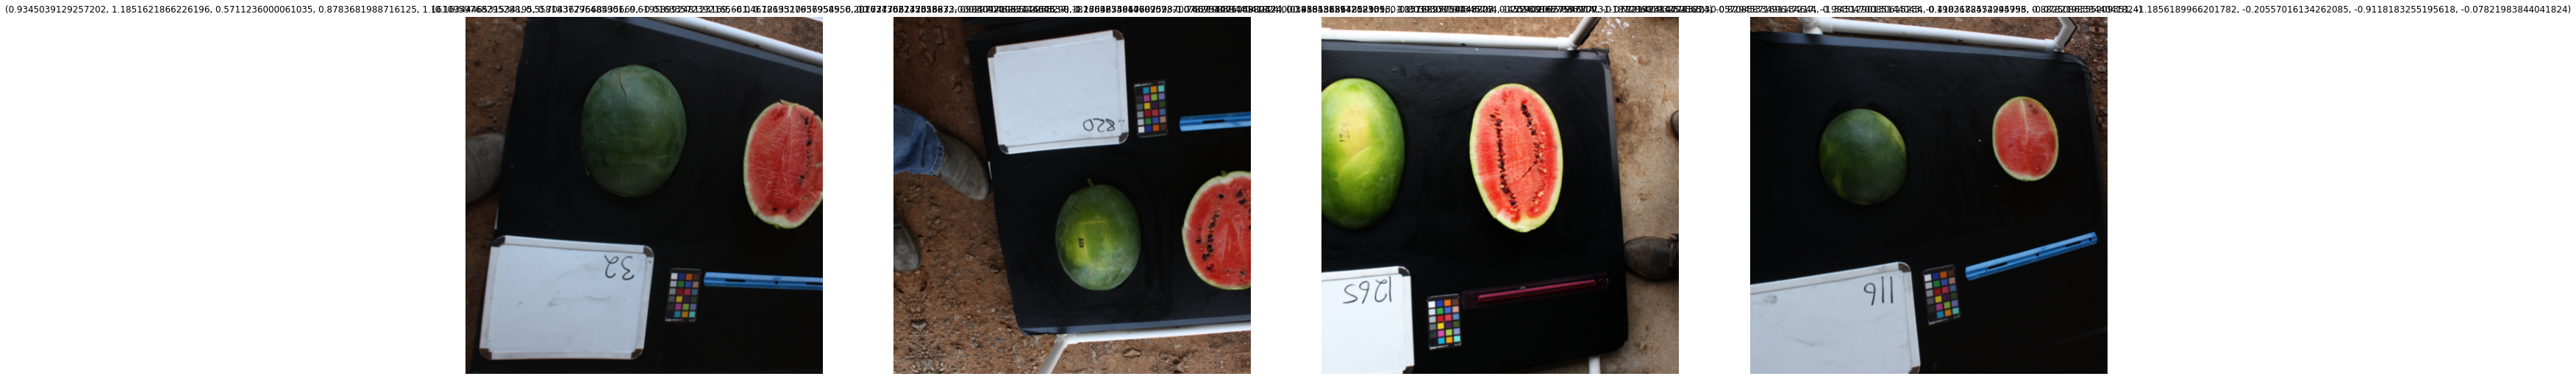

In [26]:
dls.show_batch(nrows=1, ncols=4, figsize=(40,40))

In [27]:
plant.summary(train)

Setting-up type transforms pipelines
253  1115      7407       0.725759  -0.966781    1.345821       0.803989   
10    459      6761      -0.342938   0.293366   -0.517197      -0.340227   
106   391      6928      -0.274022   0.684981   -0.692733      -0.372832   
21    478      6777       0.814650  -0.710874    1.598592       0.817235   
286   849      7456       1.502811   1.832684    0.947940       1.615027   
..    ...       ...            ...        ...         ...            ...   
137   484      6995       0.798670   0.180922    0.725595       0.840669   
162  1635      7198       0.790679   0.704368    0.706871       0.785649   
51    255      6828       0.109510  -0.187428    0.070262      -0.151732   
17    436      6769       0.226368   1.444946   -0.414217       0.231371   
26    449      6783       0.072556  -1.370027    0.856662       0.102991   

     width2_cm  heigth2_cm  prox_angl_macr  distal_angl_macr  \
253  -1.078737    1.362368       -2.513144         -2.216903  

In [28]:
dls.c = n_out_val

In [29]:
dls.c

12

In [30]:
AllData.iloc[:, 2:14].max()

perimeter1_cm                2.866147
width1_cm                    3.348737
heigth1_cm                   3.339906
perimeter2_cm                3.140309
width2_cm                    3.386046
heigth2_cm                   3.387806
prox_angl_macr               2.182559
distal_angl_macr             1.621721
tomat_pericap_area           3.416607
tomat_pericap_area_ratio     2.904337
tomat_pericap_thick          3.009001
tomat_pericap_thick_ratio    7.613398
dtype: float64

In [31]:
AllData.iloc[:, 2:14].min()

perimeter1_cm               -2.721036
width1_cm                   -2.680580
heigth1_cm                  -3.725989
perimeter2_cm               -2.742776
width2_cm                   -2.719545
heigth2_cm                  -2.670074
prox_angl_macr              -2.601485
distal_angl_macr            -5.089271
tomat_pericap_area          -2.756328
tomat_pericap_area_ratio    -4.870431
tomat_pericap_thick         -3.601682
tomat_pericap_thick_ratio   -7.769838
dtype: float64

## Training

In [32]:
model = resnet50

In [33]:
learn = cnn_learner(
               dls, 
               model, 
               metrics = [ MSELossFlat(), mae, rmse, R2Score() ], 
               loss_func = L1LossFlat(),
               y_range=(-4.0,4.0),
)

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pt

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [34]:
torch.cuda.empty_cache()
learn.fine_tune(415)

epoch,train_loss,valid_loss,None,mae,_rmse,r2_score,time
0,2.342689,1.803606,4.714135,1.803606,2.171206,-3.876713,01:43


epoch,train_loss,valid_loss,None,mae,_rmse,r2_score,time
0,2.294878,1.696740,4.266078,1.696740,2.065449,-3.413204,01:06
1,2.267014,1.684147,4.035545,1.684147,2.008867,-3.174721,01:05
2,2.235910,1.631360,3.886004,1.631360,1.971295,-3.020023,01:06
3,2.200487,1.512828,3.385135,1.512828,1.839874,-2.501880,01:07
4,2.165746,1.577927,3.508235,1.577927,1.873028,-2.629225,01:04
5,2.148045,1.511781,3.282783,1.511781,1.811845,-2.395998,01:05
6,2.116027,1.463845,3.111038,1.463845,1.763813,-2.218329,01:05
7,2.076569,1.414866,2.897743,1.414866,1.702276,-1.997679,01:04
8,2.046721,1.535230,3.401210,1.535230,1.844237,-2.518509,01:05
9,2.031276,1.478835,3.211044,1.478835,1.791939,-2.321785,01:02


42 deep still in the negs. please don't fucking quit on me again

123 at high .6 or low .7

we've got serious potential here. if i get disconnected for some bs reason i am going to call it quits. hint hint

225 4.30 

getting there

334 .72 avg

387 7.24 .74

## Inference

In [35]:
learn.export('/content/drive/MyDrive/School/ITS 530/Colab Notebooks/Mini Project 2 - Watermelonanalyzer/415epochs.pkl')
test

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
210,1225,7321,1.130265,-1.591038,1.579868,0.782592,-1.621952,1.606619,-1.493816,-2.047941,-0.151594,-0.205570,-0.547091,-0.078220,"[1.13026504070156, -1.59103777751689, 1.5798684401301244, 0.7825922890796766, -1.6219524338698375, 1.6066187746812575, -1.4938159254525591, -2.0479405030881916, -0.15159357144382382, -0.20557015459206263, -0.5470910071048539, -0.07821984063462172]"
189,876,7277,0.866587,1.320870,0.657721,0.931351,1.443866,0.604269,-0.243441,0.782187,1.530301,0.960645,1.504500,-0.078220,"[0.866586752415919, 1.3208702309092095, 0.6577211662434658, 0.9313505857407894, 1.4438655880981266, 0.6042688127928822, -0.24344076455993427, 0.7821869438245134, 1.5303014069365344, 0.9606451454975246, 1.5045002695383485, -0.07821984063462172]"
113,743,6939,1.220155,0.355404,1.406673,1.339926,0.383480,1.438408,-0.902606,-0.807120,1.215133,0.183168,0.866227,-0.078220,"[1.220155366253484, 0.35540406033917055, 1.406673266862072, 1.33992645533741, 0.383479500402896, 1.438408321306887, -0.9026059309000676, -0.8071197008037034, 1.2151331895283664, 0.18316827877113348, 0.8662274279160185, -0.07821984063462172]"
283,836,7451,-0.652560,0.398055,-1.050826,-0.676462,0.394641,-1.146963,1.027321,1.278515,-0.941011,-0.983047,-0.957409,-0.078220,"[-0.6525597494115891, 0.39805517630812787, -1.0508258132927302, -0.6764616891306975, 0.39464145922074095, -1.1469633045293375, 1.027320947868985, 1.278515264738309, -0.9410108432694385, -0.9830470213184537, -0.9574092624334942, -0.07821984063462172]"
225,1027,7355,-1.022109,-0.679855,-0.802735,-1.113567,-0.676907,-0.856627,-0.005598,0.396740,-0.665613,0.571907,-0.273546,-0.078220,"[-1.0221088655694972, -0.6798548454527973, -0.8027354299628171, -1.113566547128078, -0.6769065872923345, -0.8566274534996008, -0.005597663303184844, 0.3967404818382674, -0.6656128351135902, 0.5719067121343295, -0.2735455035524272, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,831,6858,-0.591634,-0.699242,-0.425919,-0.614309,-0.728996,-0.508685,0.374951,0.428421,-0.948281,-0.983047,-1.003000,-0.078220,"[-0.5916340843152854, -0.6992417163477783, -0.42591890433908003, -0.6143092501147515, -0.7289957284422758, -0.5086852828211069, 0.37495129870761384, 0.42842101296042573, -0.9482806664660989, -0.9830470213184537, -1.003000179692232, -0.07821984063462172]"
105,361,6927,0.668828,0.347649,0.812193,0.716364,0.353714,0.770175,-0.032780,-0.389993,1.139869,0.960645,1.185364,-0.078220,"[0.6688280362016868, 0.34764931198117843, 0.8121925369960533, 0.716364280292194, 0.35371427688864326, 0.7701750133813028, -0.03277973201824134, -0.3899927076953014, 1.1398691376099976, 0.9606451454975246, 1.1853638487271836, -0.07821984063462172]"
148,1340,7163,-2.005909,-2.537117,-1.163169,-2.140610,-2.555836,-1.236829,-1.140449,-1.303448,-1.602992,0.571907,-1.276546,7.613398,"[-2.0059085396655485, -2.5371170771919473, -1.1631686283855212, -2.1406101295554913, -2.555836321629496, -1.2368291631813981, -1.140449032156817, -1.303448021717499, -1.602992390824179, 0.5719067121343295, -1.2765456832446593, 7.613397821773313]"
167,1072,7221,-0.348930,0.510499,-0.699755,-0.453324,0.487658,-0.759849,0.938979,1.505559,-0.126791,0.183168,0.182364,-0.078220,"[-0.3489302053250913, 0.5104990274990169, -0.6997545161277584, -0.45332424413902606, 0.48765778270277865, -0.7598488364896883, 0.9389792245450489, 1.5055590711137676, -0.1267906452434525, 0.18316827877113348, 0.18236366903495146, -0.07821984063462172]"


In [36]:
dl = learn.dls.test_dl(test)

In [37]:
probs, _ = learn.get_preds( dl=dl )

In [38]:
probs.shape

torch.Size([89, 12])

In [39]:
p1 = pd.DataFrame(
           probs
)

In [40]:
p1

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.730879,-0.957269,1.365364,0.844991,-0.760249,1.407543,-1.890402,-1.679586,0.302462,-0.304135,-0.111956,-0.103253
1,1.315638,1.369397,0.940613,1.223243,1.490808,0.685673,0.985508,0.474111,1.654889,1.066442,1.615993,-0.105312
2,1.297773,0.873006,1.246681,1.295442,0.845015,1.227173,-0.084575,-0.668305,0.875780,-0.202383,0.501383,-0.065404
3,-0.224220,0.488799,-0.531314,-0.395897,0.462707,-0.707897,0.972785,0.780531,-0.330712,-0.252070,-0.212165,-0.077713
4,-0.361006,-0.110539,-0.464617,-0.548928,-0.037775,-0.701872,0.548749,0.431982,-0.487107,-0.486385,-0.361773,-0.082590
...,...,...,...,...,...,...,...,...,...,...,...,...
84,-0.072461,-0.142002,0.002152,-0.034265,-0.169405,-0.063064,-0.008603,0.128214,-0.162508,-0.071632,-0.160868,-0.069199
85,1.089377,0.676755,0.975459,1.060777,0.668022,1.012471,-0.013051,-0.551271,1.566194,1.276690,1.556334,-0.061208
86,-1.624512,-1.892191,-1.093541,-1.604929,-1.887472,-1.151224,-0.983233,-0.524099,-1.382946,0.150717,-1.271575,-0.065275
87,0.102194,0.578207,-0.242171,-0.123795,0.653329,-0.505396,1.091765,0.723817,0.048283,-0.161034,0.212430,-0.079994


## De-standardize pandas data frame

In [41]:
p1_np = p1.to_numpy()

In [42]:
p1_np

array([[ 0.73087883, -0.9572687 ,  1.3653636 , ..., -0.30413508,
        -0.11195612, -0.10325313],
       [ 1.3156376 ,  1.3693972 ,  0.94061327, ...,  1.0664425 ,
         1.6159935 , -0.10531235],
       [ 1.2977734 ,  0.87300634,  1.2466807 , ..., -0.2023828 ,
         0.5013828 , -0.06540394],
       ...,
       [-1.6245117 , -1.8921912 , -1.0935409 , ...,  0.15071726,
        -1.2715755 , -0.06527472],
       [ 0.10219383,  0.57820654, -0.24217081, ..., -0.16103363,
         0.21243   , -0.07999396],
       [ 1.2377281 ,  1.3235898 ,  0.87495565, ...,  0.3389058 ,
         1.1268115 , -0.07059574]], dtype=float32)

In [43]:

y_deviations_np = y_deviations.to_numpy()

y_deviations_np

array([1.00122009e+01, 2.57906499e+00, 4.27263639e+00, 9.81457863e+00,
       2.68770029e+00, 4.33980163e+00, 1.47155834e+01, 1.89390764e+01,
       2.33843376e+01, 2.57242381e-02, 2.19341935e-01, 1.30011663e-03])

In [44]:
y_means_np = y_means.to_numpy()

y_means_np

array([ 75.75355932,  18.55338983,  25.25979661,  79.70918644,
        19.53932203,  26.71759322, 124.68237288, 123.68610169,
        79.05491525,   0.18528814,   1.02      ,   0.20010169])

In [45]:
p1_np.shape

(89, 12)

In [46]:

## p1.astype(float)
## p1.iloc[:, 0:12] = (  p1.iloc[:, 0:12] * y_deviations   ) + y_means
## p1 = (p1 * y_deviations) + y_means


In [47]:
p1_np = (  p1_np * y_deviations_np ) + y_means_np

In [48]:
p1_np.shape

(89, 12)

In [49]:
p1_np

array([[83.07126501, 16.0845316 , 31.0934988 , ...,  0.17746449,
         0.99544333,  0.19996745],
       [88.92598719, 22.08515411, 29.2786951 , ...,  0.21272156,
         1.37445514,  0.19996478],
       [88.74712696, 20.80492993, 30.58641009, ...,  0.18008199,
         1.12997428,  0.20001666],
       ...,
       [59.4886216 , 13.67330582, 20.58749394, ...,  0.18916522,
         0.74109018,  0.20001683],
       [76.7767445 , 20.04462207, 24.22508879, ...,  0.18114567,
         1.06659481,  0.19999769],
       [88.14594193, 21.96701395, 28.99816398, ...,  0.19400623,
         1.26715702,  0.20000991]])

In [50]:
p1 = pd.DataFrame(
           p1_np, 
           columns=[ list_of_traits ]
)

In [51]:
p1

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,83.071265,16.084532,31.093499,88.002419,17.496001,32.826049,96.864010,91.876295,86.127791,0.177464,0.995443,0.199967
1,88.925987,22.085154,29.278695,91.714803,23.546167,29.693277,139.184698,132.665319,117.753390,0.212722,1.374455,0.199965
2,88.747127,20.804930,30.586410,92.423400,21.810468,32.043282,123.437800,111.029028,99.534442,0.180082,1.129974,0.200017
3,73.508628,19.814034,22.989686,75.823627,20.782940,23.645461,138.997479,138.468646,71.321427,0.178804,0.973463,0.200001
4,72.139090,18.268302,23.274657,74.321694,19.437793,23.671606,132.757534,131.867443,67.664245,0.172776,0.940648,0.199994
...,...,...,...,...,...,...,...,...,...,...,...,...
84,75.028062,18.187157,25.268991,79.372894,19.084012,26.443909,124.555780,126.114363,75.254762,0.183445,0.984715,0.200012
85,86.660625,20.298785,29.427577,90.120268,21.334764,31.111515,124.490316,113.245543,115.679326,0.218130,1.361369,0.200022
86,59.488622,13.673306,20.587494,63.957480,14.466364,21.721511,110.213530,113.760149,46.715639,0.189165,0.741090,0.200017
87,76.776745,20.044622,24.225089,78.494193,21.295274,24.524273,140.748331,137.394525,80.183984,0.181146,1.066595,0.199998


In [52]:
the_list = test["photo_id"].tolist()
the_list

[7321,
 7277,
 6939,
 7451,
 7355,
 7447,
 7220,
 6917,
 7261,
 7409,
 6916,
 6836,
 6981,
 7392,
 7380,
 7286,
 7335,
 6764,
 6884,
 6768,
 6830,
 7169,
 6784,
 6870,
 6757,
 7401,
 7416,
 6982,
 7311,
 6875,
 7303,
 6752,
 6911,
 6991,
 7417,
 7412,
 6989,
 6786,
 6910,
 7251,
 7189,
 7173,
 7403,
 7005,
 6946,
 7322,
 7741,
 7704,
 7186,
 6851,
 7013,
 6859,
 7437,
 7332,
 6861,
 6936,
 7250,
 6763,
 6815,
 6880,
 7333,
 7289,
 6988,
 6868,
 6780,
 6831,
 6838,
 7343,
 7160,
 7370,
 6846,
 6811,
 7393,
 6818,
 6775,
 6960,
 6803,
 6753,
 7432,
 6824,
 7244,
 6975,
 6943,
 7171,
 6858,
 6927,
 7163,
 7221,
 7248]

In [53]:
len(set(the_list))

89

In [54]:
p1['photo_id'] = test["photo_id"].tolist()

In [55]:


cols = ['photo_id', 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
        'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
        'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio' ]

In [56]:
p1[cols]

,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,7321,83.071265,16.084532,31.093499,88.002419,17.496001,32.826049,96.864010,91.876295,86.127791,0.177464,0.995443,0.199967
1,7277,88.925987,22.085154,29.278695,91.714803,23.546167,29.693277,139.184698,132.665319,117.753390,0.212722,1.374455,0.199965
2,6939,88.747127,20.804930,30.586410,92.423400,21.810468,32.043282,123.437800,111.029028,99.534442,0.180082,1.129974,0.200017
3,7451,73.508628,19.814034,22.989686,75.823627,20.782940,23.645461,138.997479,138.468646,71.321427,0.178804,0.973463,0.200001
4,7355,72.139090,18.268302,23.274657,74.321694,19.437793,23.671606,132.757534,131.867443,67.664245,0.172776,0.940648,0.199994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,6858,75.028062,18.187157,25.268991,79.372894,19.084012,26.443909,124.555780,126.114363,75.254762,0.183445,0.984715,0.200012
85,6927,86.660625,20.298785,29.427577,90.120268,21.334764,31.111515,124.490316,113.245543,115.679326,0.218130,1.361369,0.200022
86,7163,59.488622,13.673306,20.587494,63.957480,14.466364,21.721511,110.213530,113.760149,46.715639,0.189165,0.741090,0.200017
87,7221,76.776745,20.044622,24.225089,78.494193,21.295274,24.524273,140.748331,137.394525,80.183984,0.181146,1.066595,0.199998


In [57]:
p1

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,photo_id
0,83.071265,16.084532,31.093499,88.002419,17.496001,32.826049,96.864010,91.876295,86.127791,0.177464,0.995443,0.199967,7321
1,88.925987,22.085154,29.278695,91.714803,23.546167,29.693277,139.184698,132.665319,117.753390,0.212722,1.374455,0.199965,7277
2,88.747127,20.804930,30.586410,92.423400,21.810468,32.043282,123.437800,111.029028,99.534442,0.180082,1.129974,0.200017,6939
3,73.508628,19.814034,22.989686,75.823627,20.782940,23.645461,138.997479,138.468646,71.321427,0.178804,0.973463,0.200001,7451
4,72.139090,18.268302,23.274657,74.321694,19.437793,23.671606,132.757534,131.867443,67.664245,0.172776,0.940648,0.199994,7355
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,75.028062,18.187157,25.268991,79.372894,19.084012,26.443909,124.555780,126.114363,75.254762,0.183445,0.984715,0.200012,6858
85,86.660625,20.298785,29.427577,90.120268,21.334764,31.111515,124.490316,113.245543,115.679326,0.218130,1.361369,0.200022,6927
86,59.488622,13.673306,20.587494,63.957480,14.466364,21.721511,110.213530,113.760149,46.715639,0.189165,0.741090,0.200017,7163
87,76.776745,20.044622,24.225089,78.494193,21.295274,24.524273,140.748331,137.394525,80.183984,0.181146,1.066595,0.199998,7221


In [58]:
test

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
210,1225,7321,1.130265,-1.591038,1.579868,0.782592,-1.621952,1.606619,-1.493816,-2.047941,-0.151594,-0.205570,-0.547091,-0.078220,"[1.13026504070156, -1.59103777751689, 1.5798684401301244, 0.7825922890796766, -1.6219524338698375, 1.6066187746812575, -1.4938159254525591, -2.0479405030881916, -0.15159357144382382, -0.20557015459206263, -0.5470910071048539, -0.07821984063462172]"
189,876,7277,0.866587,1.320870,0.657721,0.931351,1.443866,0.604269,-0.243441,0.782187,1.530301,0.960645,1.504500,-0.078220,"[0.866586752415919, 1.3208702309092095, 0.6577211662434658, 0.9313505857407894, 1.4438655880981266, 0.6042688127928822, -0.24344076455993427, 0.7821869438245134, 1.5303014069365344, 0.9606451454975246, 1.5045002695383485, -0.07821984063462172]"
113,743,6939,1.220155,0.355404,1.406673,1.339926,0.383480,1.438408,-0.902606,-0.807120,1.215133,0.183168,0.866227,-0.078220,"[1.220155366253484, 0.35540406033917055, 1.406673266862072, 1.33992645533741, 0.383479500402896, 1.438408321306887, -0.9026059309000676, -0.8071197008037034, 1.2151331895283664, 0.18316827877113348, 0.8662274279160185, -0.07821984063462172]"
283,836,7451,-0.652560,0.398055,-1.050826,-0.676462,0.394641,-1.146963,1.027321,1.278515,-0.941011,-0.983047,-0.957409,-0.078220,"[-0.6525597494115891, 0.39805517630812787, -1.0508258132927302, -0.6764616891306975, 0.39464145922074095, -1.1469633045293375, 1.027320947868985, 1.278515264738309, -0.9410108432694385, -0.9830470213184537, -0.9574092624334942, -0.07821984063462172]"
225,1027,7355,-1.022109,-0.679855,-0.802735,-1.113567,-0.676907,-0.856627,-0.005598,0.396740,-0.665613,0.571907,-0.273546,-0.078220,"[-1.0221088655694972, -0.6798548454527973, -0.8027354299628171, -1.113566547128078, -0.6769065872923345, -0.8566274534996008, -0.005597663303184844, 0.3967404818382674, -0.6656128351135902, 0.5719067121343295, -0.2735455035524272, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,831,6858,-0.591634,-0.699242,-0.425919,-0.614309,-0.728996,-0.508685,0.374951,0.428421,-0.948281,-0.983047,-1.003000,-0.078220,"[-0.5916340843152854, -0.6992417163477783, -0.42591890433908003, -0.6143092501147515, -0.7289957284422758, -0.5086852828211069, 0.37495129870761384, 0.42842101296042573, -0.9482806664660989, -0.9830470213184537, -1.003000179692232, -0.07821984063462172]"
105,361,6927,0.668828,0.347649,0.812193,0.716364,0.353714,0.770175,-0.032780,-0.389993,1.139869,0.960645,1.185364,-0.078220,"[0.6688280362016868, 0.34764931198117843, 0.8121925369960533, 0.716364280292194, 0.35371427688864326, 0.7701750133813028, -0.03277973201824134, -0.3899927076953014, 1.1398691376099976, 0.9606451454975246, 1.1853638487271836, -0.07821984063462172]"
148,1340,7163,-2.005909,-2.537117,-1.163169,-2.140610,-2.555836,-1.236829,-1.140449,-1.303448,-1.602992,0.571907,-1.276546,7.613398,"[-2.0059085396655485, -2.5371170771919473, -1.1631686283855212, -2.1406101295554913, -2.555836321629496, -1.2368291631813981, -1.140449032156817, -1.303448021717499, -1.602992390824179, 0.5719067121343295, -1.2765456832446593, 7.613397821773313]"
167,1072,7221,-0.348930,0.510499,-0.699755,-0.453324,0.487658,-0.759849,0.938979,1.505559,-0.126791,0.183168,0.182364,-0.078220,"[-0.3489302053250913, 0.5104990274990169, -0.6997545161277584, -0.45332424413902606, 0.48765778270277865, -0.7598488364896883, 0.9389792245450489, 1.5055590711137676, -0.1267906452434525, 0.18316827877113348, 0.18236366903495146, -0.07821984063462172]"


## load test in dataframe to concatenate with p1 pred and compare

In [59]:
test = test.drop(['line', 'photo_id', 'combined'], axis=1)

In [60]:
test

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
210,1.130265,-1.591038,1.579868,0.782592,-1.621952,1.606619,-1.493816,-2.047941,-0.151594,-0.205570,-0.547091,-0.078220
189,0.866587,1.320870,0.657721,0.931351,1.443866,0.604269,-0.243441,0.782187,1.530301,0.960645,1.504500,-0.078220
113,1.220155,0.355404,1.406673,1.339926,0.383480,1.438408,-0.902606,-0.807120,1.215133,0.183168,0.866227,-0.078220
283,-0.652560,0.398055,-1.050826,-0.676462,0.394641,-1.146963,1.027321,1.278515,-0.941011,-0.983047,-0.957409,-0.078220
225,-1.022109,-0.679855,-0.802735,-1.113567,-0.676907,-0.856627,-0.005598,0.396740,-0.665613,0.571907,-0.273546,-0.078220
...,...,...,...,...,...,...,...,...,...,...,...,...
68,-0.591634,-0.699242,-0.425919,-0.614309,-0.728996,-0.508685,0.374951,0.428421,-0.948281,-0.983047,-1.003000,-0.078220
105,0.668828,0.347649,0.812193,0.716364,0.353714,0.770175,-0.032780,-0.389993,1.139869,0.960645,1.185364,-0.078220
148,-2.005909,-2.537117,-1.163169,-2.140610,-2.555836,-1.236829,-1.140449,-1.303448,-1.602992,0.571907,-1.276546,7.613398
167,-0.348930,0.510499,-0.699755,-0.453324,0.487658,-0.759849,0.938979,1.505559,-0.126791,0.183168,0.182364,-0.078220


In [61]:
test_np = test.to_numpy()

In [62]:
test_np = (  test_np * y_deviations_np ) + y_means_np

In [63]:
test_np.shape

(89, 12)

In [64]:
test_df = pd.DataFrame(
           test_np, 
           columns=[ list_of_traits ]
)

In [65]:
test_df

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,87.07,14.45,32.01,87.39,15.18,33.69,102.7,84.9,75.51,0.18,0.90,0.20
1,84.43,21.96,28.07,88.85,23.42,29.34,121.1,138.5,114.84,0.21,1.35,0.20
2,87.97,19.47,31.27,92.86,20.57,32.96,111.4,108.4,107.47,0.19,1.21,0.20
3,69.22,19.58,20.77,73.07,20.60,21.74,139.8,147.9,57.05,0.16,0.81,0.20
4,65.52,16.80,21.83,68.78,17.72,23.00,124.6,131.2,63.49,0.20,0.96,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...
84,69.83,16.75,23.44,73.68,17.58,24.51,130.2,131.8,56.88,0.16,0.80,0.20
85,82.45,19.45,28.73,86.74,20.49,30.06,124.2,116.3,105.71,0.21,1.28,0.20
86,55.67,12.01,20.29,58.70,12.67,21.35,107.9,99.0,41.57,0.20,0.74,0.21
87,72.26,19.87,22.27,75.26,20.85,23.42,138.5,152.2,76.09,0.19,1.06,0.20


In [66]:
test_df['photo_id'] = the_list

In [67]:
cols = ['photo_id', 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
        'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
        'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio' ]



In [68]:
test_df[cols]

,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,7321,87.07,14.45,32.01,87.39,15.18,33.69,102.7,84.9,75.51,0.18,0.90,0.20
1,7277,84.43,21.96,28.07,88.85,23.42,29.34,121.1,138.5,114.84,0.21,1.35,0.20
2,6939,87.97,19.47,31.27,92.86,20.57,32.96,111.4,108.4,107.47,0.19,1.21,0.20
3,7451,69.22,19.58,20.77,73.07,20.60,21.74,139.8,147.9,57.05,0.16,0.81,0.20
4,7355,65.52,16.80,21.83,68.78,17.72,23.00,124.6,131.2,63.49,0.20,0.96,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,6858,69.83,16.75,23.44,73.68,17.58,24.51,130.2,131.8,56.88,0.16,0.80,0.20
85,6927,82.45,19.45,28.73,86.74,20.49,30.06,124.2,116.3,105.71,0.21,1.28,0.20
86,7163,55.67,12.01,20.29,58.70,12.67,21.35,107.9,99.0,41.57,0.20,0.74,0.21
87,7221,72.26,19.87,22.27,75.26,20.85,23.42,138.5,152.2,76.09,0.19,1.06,0.20


In [69]:
test_df

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,photo_id
0,87.07,14.45,32.01,87.39,15.18,33.69,102.7,84.9,75.51,0.18,0.90,0.20,7321
1,84.43,21.96,28.07,88.85,23.42,29.34,121.1,138.5,114.84,0.21,1.35,0.20,7277
2,87.97,19.47,31.27,92.86,20.57,32.96,111.4,108.4,107.47,0.19,1.21,0.20,6939
3,69.22,19.58,20.77,73.07,20.60,21.74,139.8,147.9,57.05,0.16,0.81,0.20,7451
4,65.52,16.80,21.83,68.78,17.72,23.00,124.6,131.2,63.49,0.20,0.96,0.20,7355
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,69.83,16.75,23.44,73.68,17.58,24.51,130.2,131.8,56.88,0.16,0.80,0.20,6858
85,82.45,19.45,28.73,86.74,20.49,30.06,124.2,116.3,105.71,0.21,1.28,0.20,6927
86,55.67,12.01,20.29,58.70,12.67,21.35,107.9,99.0,41.57,0.20,0.74,0.21,7163
87,72.26,19.87,22.27,75.26,20.85,23.42,138.5,152.2,76.09,0.19,1.06,0.20,7221


In [70]:
new_p1_np   = p1.to_numpy() 
new_test_np = test_df.to_numpy()

In [71]:
combined_np = np.concatenate((new_p1_np, new_test_np), axis=0)

In [72]:
combined_np

array([[8.30712650e+01, 1.60845316e+01, 3.10934988e+01, ...,
        9.95443328e-01, 1.99967454e-01, 7.32100000e+03],
       [8.89259872e+01, 2.20851541e+01, 2.92786951e+01, ...,
        1.37445514e+00, 1.99964777e-01, 7.27700000e+03],
       [8.87471270e+01, 2.08049299e+01, 3.05864101e+01, ...,
        1.12997428e+00, 2.00016662e-01, 6.93900000e+03],
       ...,
       [5.56700000e+01, 1.20100000e+01, 2.02900000e+01, ...,
        7.40000000e-01, 2.10000000e-01, 7.16300000e+03],
       [7.22600000e+01, 1.98700000e+01, 2.22700000e+01, ...,
        1.06000000e+00, 2.00000000e-01, 7.22100000e+03],
       [8.44500000e+01, 2.10900000e+01, 2.87800000e+01, ...,
        1.23000000e+00, 2.00000000e-01, 7.24800000e+03]])

In [73]:
combined_np.shape

(178, 13)

In [74]:

list_of_traits_r = [ 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
                  'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
                  'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio', 'photo_id' ]

combined_pred_test_df = pd.DataFrame(
                                combined_np, 
                                columns=[ list_of_traits_r ]
)

In [75]:
combined_pred_test_df

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,photo_id
0,83.071265,16.084532,31.093499,88.002419,17.496001,32.826049,96.864010,91.876295,86.127791,0.177464,0.995443,0.199967,7321.0
1,88.925987,22.085154,29.278695,91.714803,23.546167,29.693277,139.184698,132.665319,117.753390,0.212722,1.374455,0.199965,7277.0
2,88.747127,20.804930,30.586410,92.423400,21.810468,32.043282,123.437800,111.029028,99.534442,0.180082,1.129974,0.200017,6939.0
3,73.508628,19.814034,22.989686,75.823627,20.782940,23.645461,138.997479,138.468646,71.321427,0.178804,0.973463,0.200001,7451.0
4,72.139090,18.268302,23.274657,74.321694,19.437793,23.671606,132.757534,131.867443,67.664245,0.172776,0.940648,0.199994,7355.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,69.830000,16.750000,23.440000,73.680000,17.580000,24.510000,130.200000,131.800000,56.880000,0.160000,0.800000,0.200000,6858.0
174,82.450000,19.450000,28.730000,86.740000,20.490000,30.060000,124.200000,116.300000,105.710000,0.210000,1.280000,0.200000,6927.0
175,55.670000,12.010000,20.290000,58.700000,12.670000,21.350000,107.900000,99.000000,41.570000,0.200000,0.740000,0.210000,7163.0
176,72.260000,19.870000,22.270000,75.260000,20.850000,23.420000,138.500000,152.200000,76.090000,0.190000,1.060000,0.200000,7221.0


In [76]:
combined_pred_test_df.to_csv('preds_vs_real.watermelon.csv') 

In [77]:
combined_pred_test_df.to_csv('/content/drive/MyDrive/School/ITS 530/Colab Notebooks/Mini Project 2 - Watermelonanalyzer/preds_vs_real.watermelon.csv')

In [81]:
## Calculate regression metrics for test data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('/content/drive/MyDrive/School/ITS 530/Colab Notebooks/Mini Project 2 - Watermelonanalyzer/PhenotypeDataUGA.csv').drop('line', axis=1)
scaler = MinMaxScaler()
traits = df.columns.values.tolist()[1:]
df.iloc[:, 1:] = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=traits)

probs = pd.DataFrame(scaler.inverse_transform(probs), columns=traits)
test = pd.DataFrame(scaler.inverse_transform(test), columns=traits)

print('Mean squared error: ' + str(mean_squared_error(test.iloc[:, :-1], probs.iloc[:, :-1])))
print('Mean absolute error: ' + str(mean_absolute_error(test.iloc[:, :-1], probs.iloc[:, :-1])))
print('R2 score: ' + str(r2_score(test.iloc[:, :-1], probs.iloc[:, :-1])))

Mean squared error: 779.119854296649
Mean absolute error: 16.280726792061078
R2 score: 0.7639485105321161
